# Deep Autoencoder applied to the stroke dataset
---

In this notebook, an *autoencoder* is implemented using `Keras` consisted of only one Dense Layer with a linear activation function.

In [ ]:
%cd ..
%cd "Notebook utilities"

In [ ]:
#Importing libraries
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd 
import random 
import tqdm 
import gc
import copy
from tqdm import tqdm
from skimage.metrics import structural_similarity as ssim
import time

import os 
from os.path import dirname, join as pjoin
from Data_Preprocessing import *

from sklearn.preprocessing import StandardScaler
from keras.layers import Input, Dense
from keras.models import Model
from tensorflow import keras
from sklearn.preprocessing import StandardScaler

import os
import sys
import inspect

In [ ]:
### Set the random seed for reproducible results
torch.manual_seed(1234)
np.random.seed(1234)

## 1.1 Loading Dataset

In [ ]:
currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

#get data
mat_path = parentdir+'/DATA/FC_Stroke/FCMatrixImage_131subj.mat'
lang_path = parentdir+'/DATA/FC_Stroke/language_score.xlsx'
Normalize = True

fc_3d, language_score, ID = get_arrays(mat_path, lang_path, Normalize)

#vectorizing matrices
vect_mat = to_vector(fc_3d)

#standarize
for i in range(len(vect_mat)):
    vect_mat[i] = (vect_mat[i] - vect_mat[i].mean())/ vect_mat[i].std()

## 1.2 Extract features

----
Feature are extracted using an `Autoencoder`. The autoencoder is only composed of one Dense layer with a linear activation function.
Adam Optimizer with learning rate 1e-3 is used.


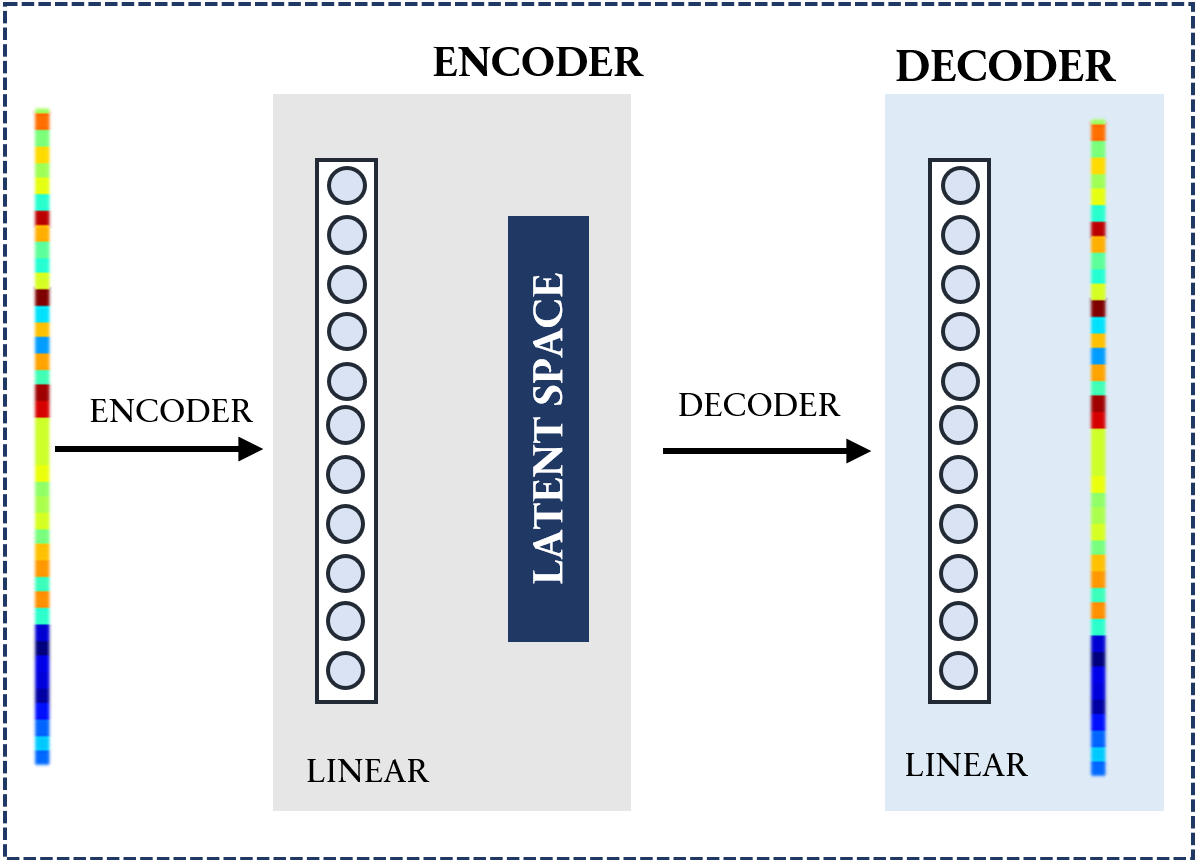


In [ ]:
components = np.arange(10, 100, 5)
hist_rer = []
inp_shape = vect_mat.shape[1]
input_img = Input(shape = (inp_shape,))
mse = np.zeros(components.shape[0])
se = np.zeros(components.shape[0])
struc = np.zeros(components.shape[0])
struc_se = np.zeros(components.shape[0])
embedded_space = {}
weigth = {}
timing = []

for i, encoding_dim in enumerate(tqdm(components)):
    name = 'n{}'.format(encoding_dim)

    start_time = time.time()
    
    #create model
    encoded = Dense(encoding_dim, activation='linear')(input_img)
    decoded = Dense(inp_shape, activation='linear')(encoded)
    # this model maps an input to its reconstruction
    autoencoder = Model(input_img, decoded)
    #Encoder
    encoder = Model(input_img, encoded)
    # create a placeholder for an encoded (32-dimensional) input
    encoded_input = Input(shape=(encoding_dim,))
    # retrieve the last layer of the autoencoder model
    decoder_layer = autoencoder.layers[-1]
    # create the decoder model
    decoder = Model(encoded_input, decoder_layer(encoded_input))
    
    opt = keras.optimizers.Adam(learning_rate=0.001)
    autoencoder.compile(optimizer=opt, loss='mse')

    history = autoencoder.fit(vect_mat,vect_mat,
                  epochs=50,
                  batch_size=16,
                  validation_split=0.1,
                  shuffle=True)



    res = autoencoder.predict(vect_mat)
    encoded_imgs = encoder.predict(vect_mat)
    decoded_imgs = decoder.predict(encoded_imgs)
    embedded_space[name] = encoded_imgs
    rer = np.mean((vect_mat - decoded_imgs)**2, 1)
    
    #SSIM index
    s_ =[ssim(vect_mat[j], decoded_imgs[j]) for j in range(len(vect_mat))]
    struc[i] = np.mean(s_)
    struc_se[i] = np.std(s_, ddof=1)
    
    hist_rer.append(rer)
    
    ##MSE 
    mse[i] =np.mean(rer)/np.sqrt(324)
    se[i] = np.std(rer, ddof=1) / np.sqrt(len(rer))
    weigth[name] = autoencoder.weights
    end_time = time.time()
    timing.append(end_time - start_time)
    print(mse)

    #plot  losses 
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model train vs validation loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper right')
    plt.savefig('Losses'+str(encoding_dim))
    plt.show()
    plt.close()
    
    
    ##plot samples
    n = 4
    idx = np.argsort(rer)
    print(idx)
    plt.figure(figsize=(8, 4))
    for i in range(n):
        # display original
        ax = plt.subplot(2, n, i + 1)
        plt.imshow(to_matrix(vect_mat[idx[i]]), cmap = 'jet')
        plt.title("original")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

        # display reconstruction
        ax = plt.subplot(2, n, i + 1 + n)
        plt.imshow(to_matrix(decoded_imgs[idx[i]]), cmap = 'jet')
        plt.title("reconstructed")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
        
    plt.savefig('Linear_Recostructed_Images_'+str(encoding_dim))
    plt.show()
    plt.close()

## 1.3 Saving features


In [ ]:
np.savetxt('MSE_LINEARAE.txt', mse)
np.savetxt('SD_LINEARAE.txt', se)

In [ ]:
import pickle
a_file = open("FEATURES_LINEARAE.pkl", "wb")
pickle.dump(embedded_space, a_file)
a_file.close()

a_file = open("WEIGHTS_LINEARAE.pkl", "wb")
pickle.dump(weigth, a_file)
a_file.close()

In [ ]:
data = pd.DataFrame(histogram_rer)
data.index = ['10', '50', '90']
import seaborn as sns
sns.set(font_scale = 2)
plt.figure(figsize=(15,7))
sns.kdeplot(data=data.T, fill=True, common_norm=False, palette="Accent",
   alpha=.5, linewidth=2)
plt.savefig('Distribution_Linear')
data.to_csv('linear_distribution.csv')